In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from hela.visualization.hmm import TU_COLORS

In [2]:
wt01 = pd.read_parquet('data/hmm_data_preparation/hmm_processed_wt_data/wt01_hmm_training_data.pq')
wt02 = pd.read_parquet('data/hmm_data_preparation/hmm_processed_wt_data/wt02_hmm_training_data.pq')

In [3]:
print(wt01['WTOperationState'].unique())
print(len(wt01))
wt01.head()

['stopped due to external error' 'in operation'
 'stopped due to turbine error' 'in regular maintenance mode']
52705


,gen_rpm,active_power,reactive_power,amb_windspeed,WTOperationState
2016-01-01 00:00:00,10.104447,6.826118,5.400763,7.196133,stopped due to external error
2016-01-01 00:10:00,9.491918,6.736402,5.167712,6.813591,stopped due to external error
2016-01-01 00:20:00,8.852241,6.626578,4.898107,6.418325,stopped due to external error
2016-01-01 00:30:00,6.703990,6.061869,5.337347,4.971730,stopped due to external error
2016-01-01 00:40:00,7.802003,6.412470,5.277956,5.944557,stopped due to external error


In [4]:
wt02 = wt02.rename(columns= {col: col + '_02' for col in wt02.columns})
print(len(wt02))
wt02.head()

52705


,gen_rpm_02,active_power_02,reactive_power_02,amb_windspeed_02,WTOperationState_02
2016-01-01 00:00:00,2.818319,2.423220,5.225334,6.296926,stopped due to turbine error
2016-01-01 00:10:00,2.797143,2.418335,5.225334,6.029453,stopped due to turbine error
2016-01-01 00:20:00,2.801702,2.434481,5.225334,6.029053,stopped due to turbine error
2016-01-01 00:30:00,2.783530,2.428123,5.225334,4.258594,stopped due to turbine error
2016-01-01 00:40:00,2.808062,2.433555,5.225334,5.168023,stopped due to turbine error


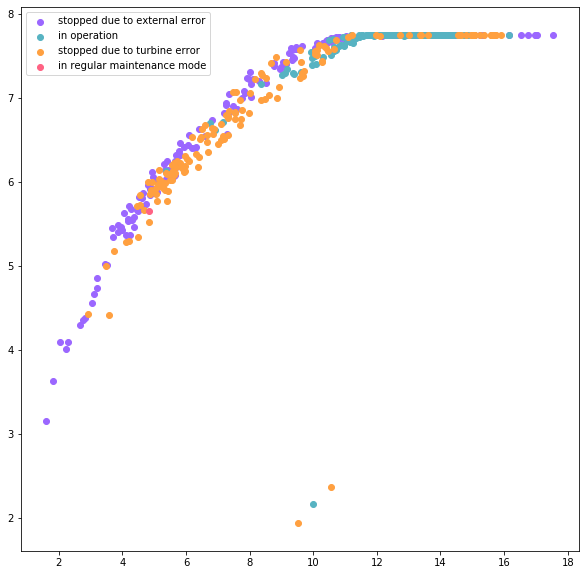

In [5]:
color_dict = {}
operating_state = wt01['WTOperationState'].unique()
for i, status in enumerate(operating_state):
    color_dict[status] = TU_COLORS[i]

df = wt01.iloc[:500][['amb_windspeed', 'active_power', 'WTOperationState']]

plt.figure(figsize = (10,10))
for status in color_dict.keys():
    rows = df.loc[df['WTOperationState'] == status]
    plt.scatter(rows['amb_windspeed'],rows['active_power'], color = color_dict[status],label = status)

plt.legend()
plt.show()

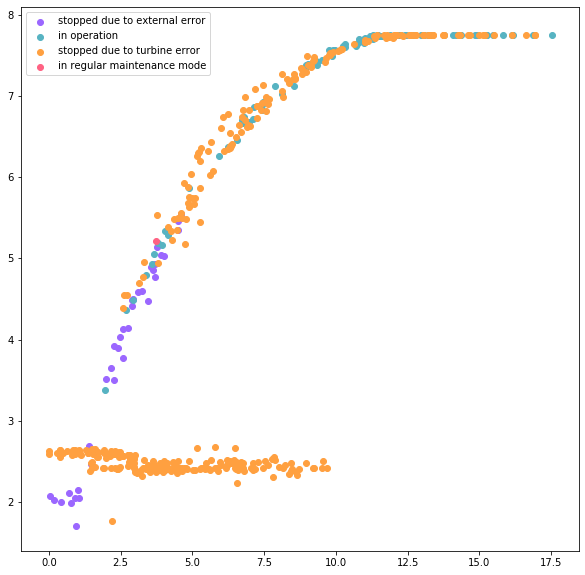

In [6]:
df = wt02.iloc[1000:1500][['amb_windspeed_02', 'active_power_02', 'WTOperationState_02']]

plt.figure(figsize = (10,10))
for status in color_dict.keys():
    rows = df.loc[df['WTOperationState_02'] == status]
    plt.scatter(rows['amb_windspeed_02'],rows['active_power_02'], color = color_dict[status],label = status)

plt.legend()
plt.show()

In [7]:
hidden_state_1 = pd.DataFrame(wt01["WTOperationState"])
hidden_state_2 = pd.DataFrame(wt02["WTOperationState_02"])
hidden_states = hidden_state_1.join(hidden_state_2, how='outer')
hidden_states.head()

,WTOperationState,WTOperationState_02
2016-01-01 00:00:00,stopped due to external error,stopped due to turbine error
2016-01-01 00:10:00,stopped due to external error,stopped due to turbine error
2016-01-01 00:20:00,stopped due to external error,stopped due to turbine error
2016-01-01 00:30:00,stopped due to external error,stopped due to turbine error
2016-01-01 00:40:00,stopped due to external error,stopped due to turbine error


In [8]:
hidden_state_mapping = dict(zip(operating_state, [i for i in range(len(operating_state))]))
hidden_states['WTOperationState'] = hidden_states['WTOperationState'].map(hidden_state_mapping)
hidden_states['WTOperationState_02'] = hidden_states['WTOperationState_02'].map(hidden_state_mapping)
hidden_states.head()

,WTOperationState,WTOperationState_02
2016-01-01 00:00:00,0,2
2016-01-01 00:10:00,0,2
2016-01-01 00:20:00,0,2
2016-01-01 00:30:00,0,2
2016-01-01 00:40:00,0,2


In [9]:
hidden_state_tuples = np.array(hidden_states.drop_duplicates())
hidden_state_tuples
hidden_state_dict = {
    str(list(hidden_state_tuples[i])): i
    for i in range(len(hidden_state_tuples))
}

flattened_states = pd.Series(
                    [hidden_state_dict[str(list(v))] for v in np.array(hidden_states)],
                    index=hidden_states.index)

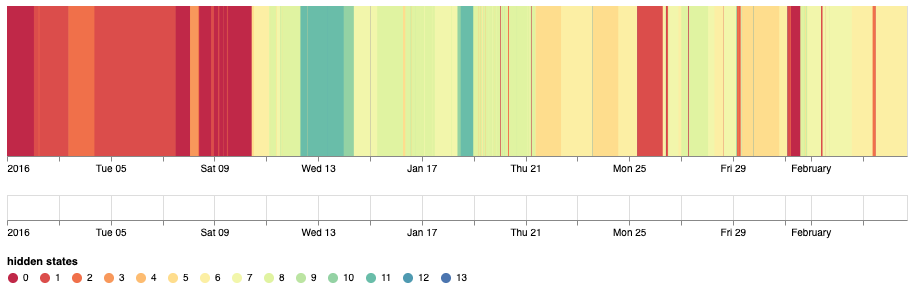

In [10]:
import altair as alt
import hela.visualization.hmm as hmmplot 
hmmplot.draw_states(flattened_states[:5000], hide_brush=False)

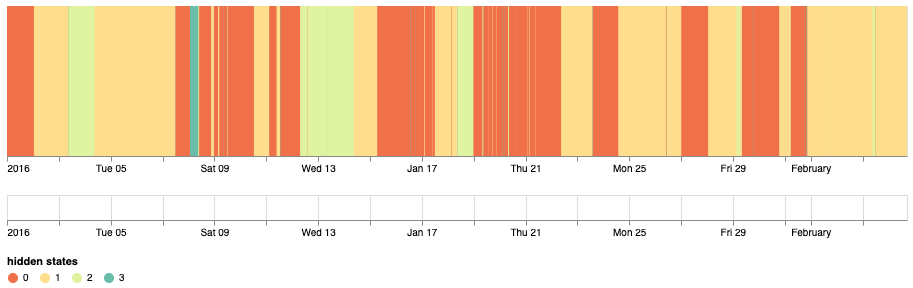

In [11]:
hmmplot.draw_states(hidden_states[:5000]["WTOperationState"], hide_brush=False)

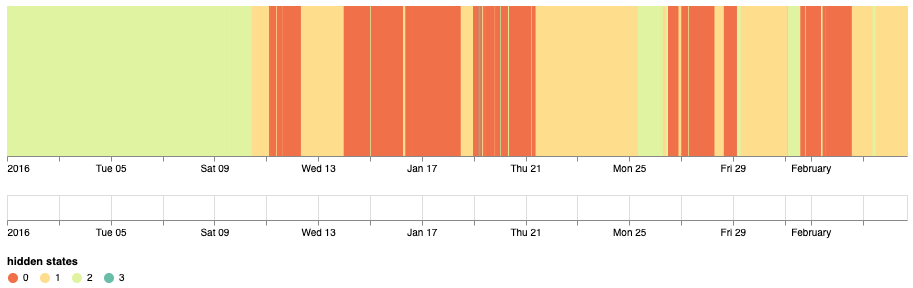

In [12]:
hmmplot.draw_states(hidden_states[:5000]["WTOperationState_02"], hide_brush=False)

In [25]:
data = wt01[['gen_rpm', 'active_power', 'reactive_power', 'amb_windspeed']].join(
                    wt02[['gen_rpm_02','active_power_02', 'reactive_power_02', 'amb_windspeed_02']])
data.head()

,gen_rpm,active_power,reactive_power,amb_windspeed,gen_rpm_02,active_power_02,reactive_power_02,amb_windspeed_02
2016-01-01 00:00:00,10.104447,6.826118,5.400763,7.196133,2.818319,2.423220,5.225334,6.296926
2016-01-01 00:10:00,9.491918,6.736402,5.167712,6.813591,2.797143,2.418335,5.225334,6.029453
2016-01-01 00:20:00,8.852241,6.626578,4.898107,6.418325,2.801702,2.434481,5.225334,6.029053
2016-01-01 00:30:00,6.703990,6.061869,5.337347,4.971730,2.783530,2.428123,5.225334,4.258594
2016-01-01 00:40:00,7.802003,6.412470,5.277956,5.944557,2.808062,2.433555,5.225334,5.168023


8


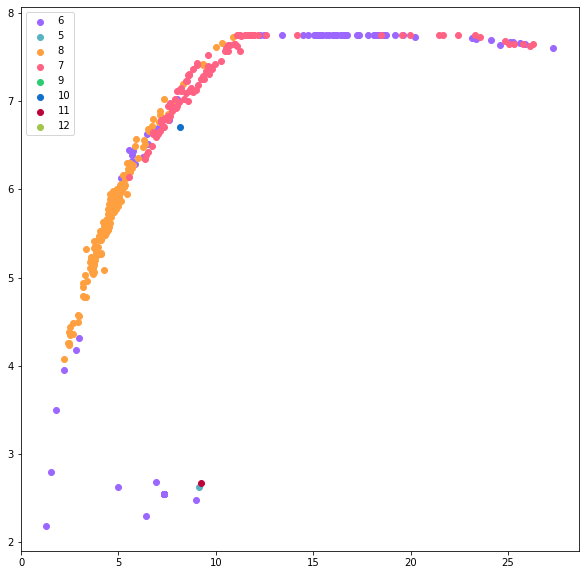

In [26]:
# WT01 scatterplot

plt.figure(figsize = (10,10))
feat = ['amb_windspeed','active_power']
print(len(flattened_states[1500:2000].unique()))
states = flattened_states[1500:2000]
data_plot = data[1500:2000]
color_dict = dict(zip(states.unique(),
        [TU_COLORS[state] for state in range(len(states.unique()))]))
for k in color_dict.keys():
    idx = np.where(flattened_states[3500:4000] == k)
    df = np.array(data_plot.loc[data_plot.index[idx],feat])
    plt.scatter([d[0] for d in df],[d[1] for d in df], color = color_dict[k] ,label = k)

plt.legend()
plt.show()


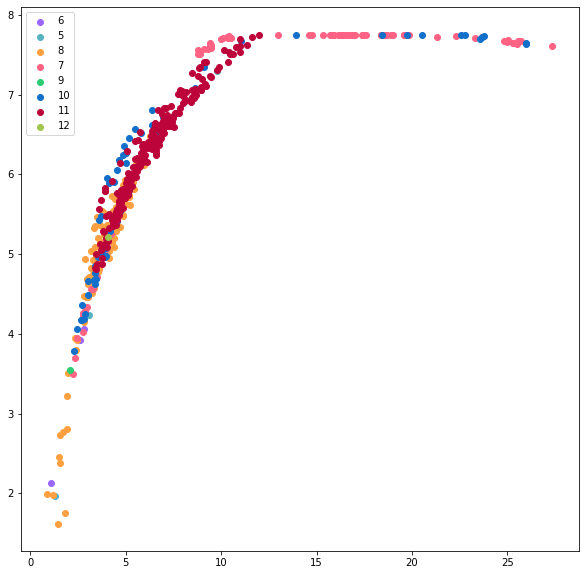

In [27]:
# WT02 scatterplot

plt.figure(figsize = (10,10))
feat = ['amb_windspeed_02', 'active_power_02']

color_dict = dict(zip(states.unique(),
        [TU_COLORS[state] for state in range(len(states.unique()))]))
for k in color_dict.keys():
    idx = np.where(states == k)
    df = np.array(data_plot.loc[data_plot.index[idx],feat])
    plt.scatter([d[0] for d in df],[d[1] for d in df], color = color_dict[k] ,label = k)

plt.legend()
plt.show()


8


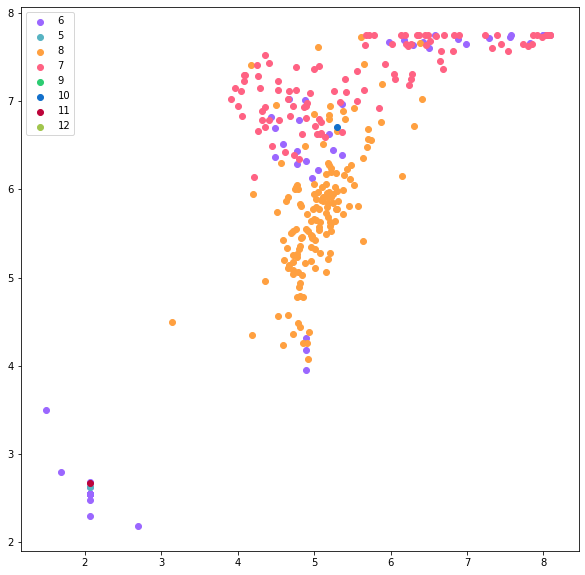

In [29]:
# WT01 scatterplot

plt.figure(figsize = (10,10))
feat = ['reactive_power','active_power']
print(len(flattened_states[1500:2000].unique()))
states = flattened_states[1500:2000]
data_plot = data[1500:2000]
color_dict = dict(zip(states.unique(),
        [TU_COLORS[state] for state in range(len(states.unique()))]))
for k in color_dict.keys():
    idx = np.where(flattened_states[3500:4000] == k)
    df = np.array(data_plot.loc[data_plot.index[idx],feat])
    plt.scatter([d[0] for d in df],[d[1] for d in df], color = color_dict[k] ,label = k)

plt.legend()
plt.show()

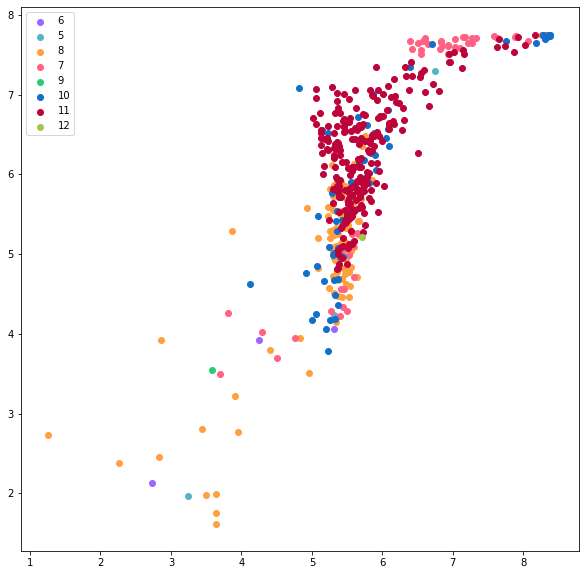

In [31]:
# WT02 scatterplot

plt.figure(figsize = (10,10))
feat = ['reactive_power_02', 'active_power_02']

color_dict = dict(zip(states.unique(),
        [TU_COLORS[state] for state in range(len(states.unique()))]))
for k in color_dict.keys():
    idx = np.where(states == k)
    df = np.array(data_plot.loc[data_plot.index[idx],feat])
    plt.scatter([d[0] for d in df],[d[1] for d in df], color = color_dict[k] ,label = k)

plt.legend()
plt.show()


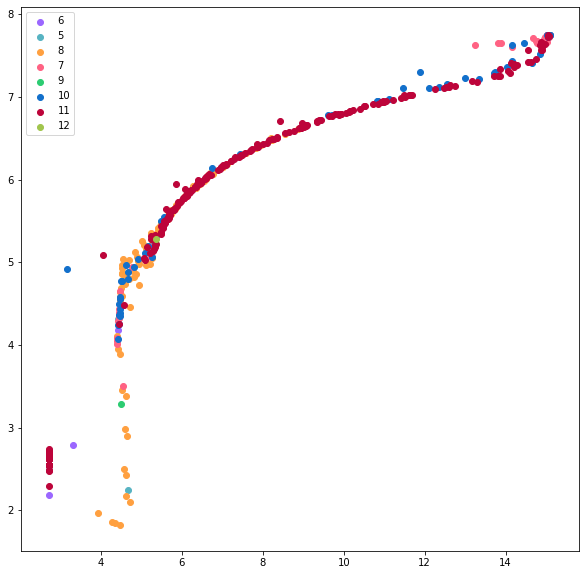

In [32]:
# WT01 scatterplot

plt.figure(figsize = (10,10))
feat = ['gen_rpm', 'active_power']

color_dict = dict(zip(states.unique(),
        [TU_COLORS[state] for state in range(len(states.unique()))]))
for k in color_dict.keys():
    idx = np.where(states == k)
    df = np.array(data_plot.loc[data_plot.index[idx],feat])
    plt.scatter([d[0] for d in df],[d[1] for d in df], color = color_dict[k] ,label = k)

plt.legend()
plt.show()


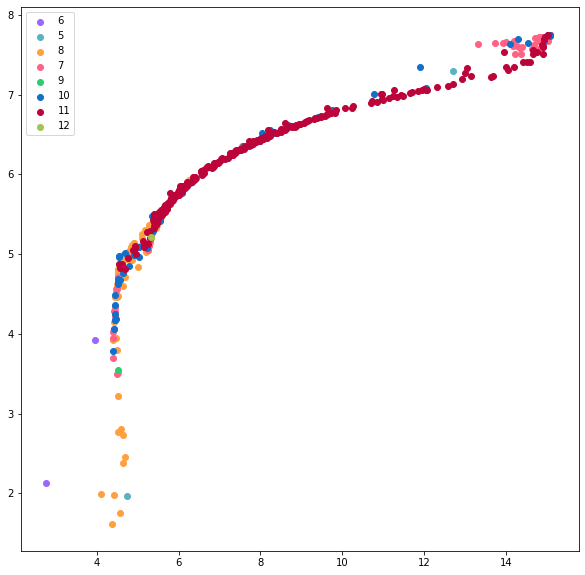

In [33]:
# WT01 scatterplot

plt.figure(figsize = (10,10))
feat = ['gen_rpm_02', 'active_power_02']

color_dict = dict(zip(states.unique(),
        [TU_COLORS[state] for state in range(len(states.unique()))]))
for k in color_dict.keys():
    idx = np.where(states == k)
    df = np.array(data_plot.loc[data_plot.index[idx],feat])
    plt.scatter([d[0] for d in df],[d[1] for d in df], color = color_dict[k] ,label = k)

plt.legend()
plt.show()


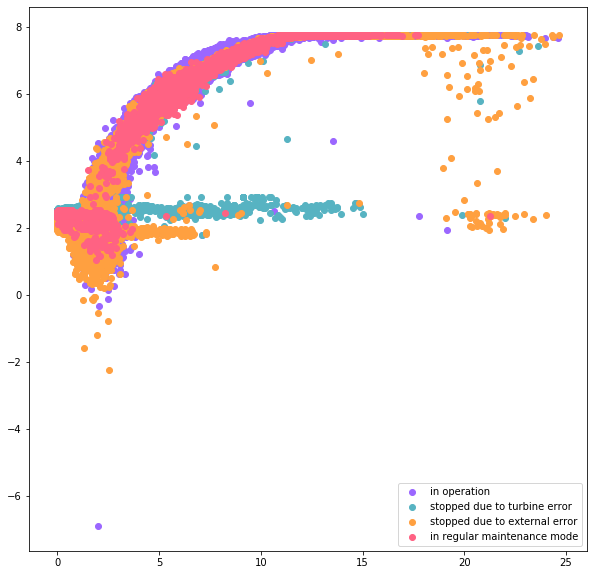

In [230]:
color_dict = {}
for i, status in enumerate(wt01['WTOperationState'].unique()):
    color_dict[status] = TU_COLORS[i]

df = wt01_tor[['amb_windspeed', 'active_power', 'WTOperationState']]

plt.figure(figsize = (10,10))
for status in color_dict.keys():
    rows = df.loc[df['WTOperationState'] == status]
    plt.scatter(rows['amb_windspeed'],rows['active_power'], color = color_dict[status],label = status)

plt.legend()
plt.show()

In [41]:
print("Number of tor events wt02: ", len(df.loc[wt02_tor['tor'] == 1]))

df.loc[wt02_tor['tor'] == 1]

Number of tor events wt02:  12


,gen_rpm,active_power,reactive_power,amb_windspeed,WTOperationState
2016-09-24 11:30:00,15.068324,7.750442,8.098014,13.202633,stopped due to external error
2016-09-25 11:20:00,12.392958,7.282891,4.686356,8.674610,in operation
2016-09-25 16:20:00,14.950784,7.733224,7.124485,11.556898,in operation
2016-09-25 16:50:00,14.636770,7.595920,7.823283,10.246350,in operation
2016-09-26 16:50:00,7.809904,6.381884,5.320039,6.510325,in operation
2016-09-27 07:50:00,13.348630,7.467140,7.042315,9.242987,stopped due to external error
2016-09-27 08:40:00,14.181008,7.559970,7.850629,9.722584,stopped due to external error
2016-09-28 04:50:00,6.275182,5.870889,5.114620,4.945045,stopped due to external error
2016-09-28 05:10:00,4.942162,5.988765,4.913018,5.957736,in operation
2016-09-28 09:20:00,14.571373,7.647337,7.646149,10.792042,in operation


In [37]:
df_train['WTOperationState'].unique()

array(['stopped due to external error', 'in operation',
       'stopped due to turbine error', 'in regular maintenance mode'],
      dtype=object)

In [38]:
print("Occurences of external error: ", len(df.loc[wt01['WTOperationState'] == 'stopped due to external error']))
print("Occurences of in operation: ", len(df.loc[wt01['WTOperationState'] == 'in operation']))
print("Occurences of turbine error: ", len(df.loc[wt01['WTOperationState'] == 'stopped due to turbine error']))
print("Occurences of regular maintenance: ", len(df.loc[wt01['WTOperationState'] == 'in regular maintenance mode']))

Occurences of external error:  12842
Occurences of in operation:  36819
Occurences of turbine error:  2172
Occurences of regular maintenance:  872


In [43]:
t_wt01 = pd.read_parquet('data/platform/02_17_2021/teesside_wt01.pq')
t_wt01.head()

,asset_id,hazard,event_probability_1wk
2016-01-01 00:00:00,teesside_wt01,NaN,NaN
2016-01-01 01:00:00,teesside_wt01,NaN,NaN
2016-01-01 02:00:00,teesside_wt01,NaN,NaN
2016-01-01 03:00:00,teesside_wt01,NaN,NaN
2016-01-01 04:00:00,teesside_wt01,NaN,NaN


In [45]:
# Individual Saga Blocks
re_active_df = pd.read_parquet('data/saga_data/teesside_wt_01_edf_preprocessed_alex_yee_re_active_power_avg_sql_10_min_avg_20160101000000_20170701000000.pq')
amb_wind_speed_df = pd.read_parquet('data/saga_data/teesside_wt_01_edf_preprocessed_alex_yee_amb_wind_speed_avg_sql_10_min_avg_20160101000000_20170701000000.pq')
trafo_temp_df = pd.read_parquet('data/saga_data/teesside_wt_01_edf_preprocessed_alex_yee_trafo_temp_20160101000000_20170701000000.pq')
trafo_room_temp_df = pd.read_parquet('data/saga_data/teesside_wt_01_edf_preprocessed_alex_yee_trafo_room_temp_20160101000000_20170701000000.pq')


In [54]:
# Entire DF for Turbine 1
sync_df = pd.read_parquet('data/interim_phase_1_sync/WT01_sync.pq')

In [ ]:
# synchronous features used in TTE
SYNC_FEAT =  ['active_power_avg_sql_10_min_avg', #power generated
              'amb_wind_speed_avg_sql_10_min_avg', #wind - external
              'amb_wind_speed_1_avg_sql_10_min_avg',#wind - external
              'amb_wind_speed_2_avg_sql_10_min_avg',#wind - external
              'ambient_temp_avg_sql_10_min_avg', # temp external
              'blds_blade_a_pitch_angle_avg_sql_10_min_avg', # internal
              #'blds_blade_a_pitch_angle_ref_avg_sql_10_min_avg',
              'blds_blade_b_pitch_angle_avg_sql_10_min_avg', # internal
              #'blds_blade_b_pitch_angle_ref_avg_sql_10_min_avg',
              'blds_blade_c_pitch_angle_avg_sql_10_min_avg', # internal
              #'blds_blade_c_pitch_angle_ref_avg_sql_10_min_avg',
              'current_l_1_avg_sql_10_min_avg', # L1 pitch angle controller
              'current_l_2_avg_sql_10_min_avg', # L2 pitch angle controller
              'current_l_3_avg_sql_10_min_avg', # L3 pitch angle controller
              'frequency_avg_sql_10_min_avg', # Freq of blades
              'gen_rpm_avg_sql_10_min_avg', # Rotations per minute
              'nacelle_temp_avg_sql_10_min_avg', # Sits on top of tower
              'power_factor_sql_10_min_avg', # Power generated I'm assuming
              're_active_power_avg_sql_10_min_avg', # Amount of unusued power
              'rtr_rpm_avg_sql_10_min_avg', # Rotar rpm
              #'tower_humidity_avg_sql_10_min_avg',   # this seems to cause limited models, dominating?
              'voltage_l_1_avg_sql_10_min_avg',
              'voltage_l_2_avg_sql_10_min_avg',
              'voltage_l_3_avg_sql_10_min_avg',
              'windspeed_gust_max_total_sql_10_min_avg',
              'windspeed_mean_total_sql_10_min_avg',
              'yaw_position_avg_sql_10_min_avg',
             ]
# other features used in TTE:
ERROR = [     'error_code_13110', 
              'error_code_13902', 
              'error_code_14214', 
              'error_code_15324', 
              'error_code_emergency_switch_activated', 
              'error_code_inv._cool._w._temp_high',  
              'error_code_inv._cooling_water_temp._warn.', 
              'error_code_t._o._r_converter_coolant_heater', 
              'error_code_t._o._r_converter_coolant_pump', 
              'error_code_t._o._r_converter_fan_(_tower)', 
              'error_code_tor_transfor._ventilation',   
              'error_code_tower_emergency_contact._err',              
             ]
STATUS =     ['wps_status_fault_condition',
              'wps_status_no_communication_with_wtc',
              'wps_status_service_mode'
             ]
OPERATION =  ['wtoperation_state_cable_untwisting_procedure_active',
              'wtoperation_state_pitchlubrication_procedure_active',
              'wtoperation_state_stopped_due_to_grid_error',
              'wtoperation_state_stopped_due_to_high_wind',
              'wtoperation_state_waiting_for_sufficient_wind_speed',
              'wtoperation_state_remote_stop_command_is_active',
              'wtoperation_state_stopped_due_to_internal_error._autoreset_when_error_state_has_gone',
              'wtoperation_state_stopped_due_to_internal_error._manual_reset_is_required.',
             ]
OTHER    =   ['hyd_pressure', 
              'TrafoTemp',
              'TrafoRoomTemp',
             ]

In [73]:
OTHER    =   [
              'HydPressure', # Not sure if this is useful
              'TrafoTemp', # Recommended by Robert as good indicator of TOR
              'TrafoRoomTemp',# Recommended by Robert as good indicator of TOR
             ]


,HydPressure,TrafoTemp,TrafoRoomTemp
DateTime_10minAvg,,,
2016-01-01 00:00:00,233.661865,56.664261,21.970734
2016-01-01 00:10:00,236.160000,55.616814,21.485367
2016-01-01 00:20:00,236.416667,54.569366,21.000000
2016-01-01 00:30:00,236.000000,53.521919,21.000000
2016-01-01 00:40:00,235.608696,52.474472,20.000000
...,...,...,...
2017-06-30 23:20:00,235.481481,66.666667,33.777278
2017-06-30 23:30:00,234.851852,66.333333,34.036370
2017-06-30 23:40:00,234.843750,66.000000,34.295463


In [234]:
status_codes = [col for col in sync_df if col.startswith('Wps')]
for status in status_codes:
    count = len(sync_df.loc[sync_df[status] == True])
    print(status, count)

WpsStatus_Fault condition 4262
WpsStatus_Faultless 2292
WpsStatus_Intf Shut 1
WpsStatus_No communication with WTC 202
WpsStatus_Not Connect 2
WpsStatus_Service mode 181
WpsStatus__n_transitions 900


In [233]:
operating_status_codes = [col for col in sync_df if col.startswith('WTOperation')]
for status in operating_status_codes:
    count = len(sync_df.loc[sync_df[status] == True])
    print(status, count)

WTOperationState_Cable untwisting procedure active 39
WTOperationState_In operation : Generator on grid 6388
WTOperationState_In operation, Waiting for grid 1246
WTOperationState_Intf Shut 1
WTOperationState_Not Connect 2
WTOperationState_Pitchlubrication procedure active 104
WTOperationState_Ready for production : Waiting for "Release operation" command 37
WTOperationState_Remote Stop Command is active 132
WTOperationState_Stopped due to grid error 7
WTOperationState_Stopped due to high wind 0
WTOperationState_Stopped due to internal error. Autoreset when error state has gone 66
WTOperationState_Stopped due to internal error. Manual reset is required. 203
WTOperationState_Waiting for sufficient wind speed 2272
WTOperationState__n_transitions 1316


In [115]:
ambient_wind_speed = [col for col in sync_df if col.startswith('Amb')]
ambient_wind_speed

['Amb_WindSpeed1_Avg-SQL-10minAvg',
 'Amb_WindSpeed1_Max-SQL-10minAvg',
 'Amb_WindSpeed1_Min-SQL-10minAvg',
 'Amb_WindSpeed1_Std-SQL-10minAvg',
 'Amb_WindSpeed2_Avg-SQL-10minAvg',
 'Amb_WindSpeed2_Max-SQL-10minAvg',
 'Amb_WindSpeed2_Min-SQL-10minAvg',
 'Amb_WindSpeed2_Std-SQL-10minAvg',
 'Amb_WindSpeed_Avg-SQL-10minAvg',
 'Amb_WindSpeed_Max-SQL-10minAvg',
 'Amb_WindSpeed_Min-SQL-10minAvg',
 'Amb_WindSpeed_Std-SQL-10minAvg',
 'AmbientTemp_Avg-SQL-10minAvg']

In [117]:
active_power_codes = [col for col in sync_df if col.startswith("ActivePower")]
active_power_codes

['ActivePower_Avg-SQL-10minAvg',
 'ActivePower_Max-SQL-10minAvg',
 'ActivePower_Min-SQL-10minAvg']

In [119]:
re_active_power_codes = [col for col in sync_df if col.startswith("ReActivePower")]
re_active_power_codes

['ReActivePower_Avg-SQL-10minAvg']

In [121]:
power_generated = [col for col in sync_df if col.startswith("Gen")]
power_generated

['Gen_RPM_Avg-SQL-10minAvg',
 'Gen_RPM_Max-SQL-10minAvg',
 'Gen_RPM_Min-SQL-10minAvg',
 'Gen_RPM_Std-SQL-10minAvg',
 'Gen1EnergySub-SQL-10minAvg',
 'Gen1EnergyTotal-SQL-10minAvg',
 'GenBerGTemp',
 'GenBerRTemp']

### Tor Error Codes to find
- "12109": "Transf. Ventilation"
- "13319": "Converter Fan 1"
- "13320": "Converter Fan 2"
- "13302": "Inv. Cool. Water Temp Warn"
- "13303": "Inv. Cool. Water Temp High"

In [260]:
tor_codes = [col for col in sync_df if col.startswith('ErrorCode_T') or col.startswith('ErrorCode_Inv') or col.startswith('C')]
for code in tor_codes:
    count = len(sync_df.loc[sync_df[code] == True])
#     print(count)
    print("{}: {}".format(code, count))

CurrentL1_Avg-SQL-10minAvg: 0
CurrentL2_Avg-SQL-10minAvg: 0
CurrentL3_Avg-SQL-10minAvg: 0
ErrorCode_Inv. Tow coolw. pres. sens err: 0
ErrorCode_Inv. cool. w. temp high: 0
ErrorCode_Inv. cooling water temp. warn.: 0
ErrorCode_Inv.(tow) coolwater pres. low: 0
ErrorCode_Inv.(tow) coolwater pres. war: 0
ErrorCode_Inverter modbus com. error: 3
ErrorCode_T.O.R Converter coolant heater: 0
ErrorCode_T.O.R Converter coolant pump: 1
ErrorCode_T.O.R Converter fan  (Tower): 1
ErrorCode_TOR transfor. ventilation: 0
ErrorCode_Temp. in A (right) too high: 0
ErrorCode_Too many yaw conv. errors: 0
ErrorCode_Too many yaw conv. warnings: 0
ErrorCode_Tower emergency contact. err: 0
ErrorCode_Tower vent. TOR: 0
ErrorCode_Tower vibration, waiting: 2
ErrorCode_Transfo. oil pressure too high: 1
ErrorCode_Transfo. room temp. sens. err.: 0
ErrorCode_Transformer oil level too low: 1
ErrorCode_Turbine Serial Number invalid: 0
ErrorCode_Turbine in local operation: 26


In [122]:
possible_tor_codes = [ 
              'ErrorCode_Tower vent. TOR', # Code 12109
              'ErrorCode_Inv. cool. w. temp high', # Code 13303  
              'ErrorCode_Inv. cooling water temp. warn.',  # Code 13302
#               'ErrorCode_T.O.R Converter coolant heater', 
#               'ErrorCode_T.O.R Converter coolant pump', 
              'ErrorCode_T.O.R Converter fan  (Tower)', # Code 13319 and Code 13320
#               'ErrorCode_TOR transfor. ventilation',   
#               'ErrorCode_Tower emergency contact. err',              
             ]

In [252]:
tor_event = sync_df.loc[sync_df['ErrorCode_T.O.R Converter fan  (Tower)'] == True].index
time_after = pd.date_range(start = tor_event[0], periods=15, freq='10Min')
time_before = pd.date_range(end = tor_event[0], periods=100, freq='10Min')
total_time = pd.date_range(start = time_before[0], end = time_after[-1], freq="10Min")
# total_time
sync_df.loc[total_time][['Amb_WindSpeed_Avg-SQL-10minAvg', 'ActivePower_Avg-SQL-10minAvg']]


,Amb_WindSpeed_Avg-SQL-10minAvg,ActivePower_Avg-SQL-10minAvg
2016-03-28 16:20:00,0.000000,0.000000
2016-03-28 16:30:00,0.000000,0.000000
2016-03-28 16:40:00,0.000000,0.000000
2016-03-28 16:50:00,0.000000,0.000000
2016-03-28 17:00:00,0.000000,0.000000
...,...,...
2016-03-29 10:30:00,5.093194,128.267273
2016-03-29 10:40:00,5.180332,376.254425
2016-03-29 10:50:00,5.085178,339.884033
2016-03-29 11:00:00,6.265187,535.443542


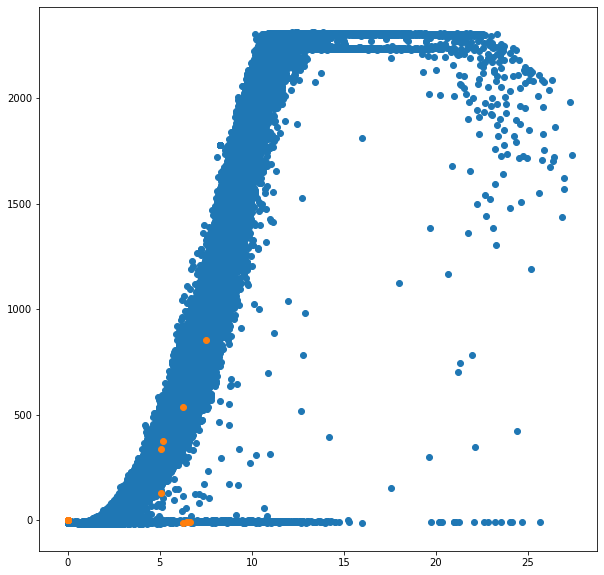

In [253]:
plt.figure(figsize = (10,10))
plt.scatter(sync_df['Amb_WindSpeed_Avg-SQL-10minAvg'], sync_df['ActivePower_Avg-SQL-10minAvg'])
plt.scatter(sync_df.loc[total_time]['Amb_WindSpeed_Avg-SQL-10minAvg'], 
            sync_df.loc[total_time]['ActivePower_Avg-SQL-10minAvg'])

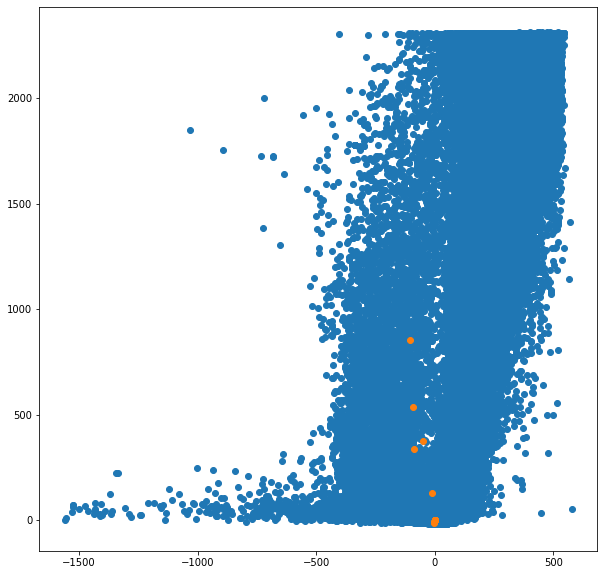

In [255]:
plt.figure(figsize = (10,10))
plt.scatter(sync_df['ReActivePower_Avg-SQL-10minAvg'], sync_df['ActivePower_Avg-SQL-10minAvg'])
plt.scatter(sync_df.loc[total_time]['ReActivePower_Avg-SQL-10minAvg'], 
            sync_df.loc[total_time]['ActivePower_Avg-SQL-10minAvg'])

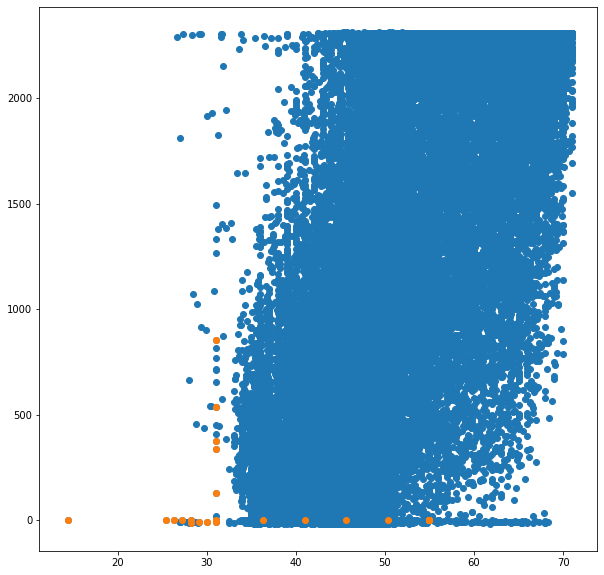

In [249]:
plt.figure(figsize = (10,10))
plt.scatter(sync_df['TrafoTemp'], sync_df['ActivePower_Avg-SQL-10minAvg'])
plt.scatter(sync_df.loc[total_time]['TrafoTemp'], 
            sync_df.loc[total_time]['ActivePower_Avg-SQL-10minAvg'])

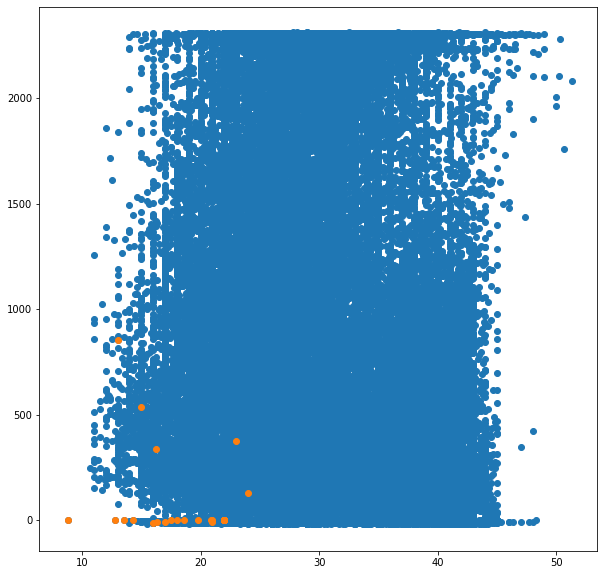

In [250]:
plt.figure(figsize = (10,10))
plt.scatter(sync_df['TrafoRoomTemp'], sync_df['ActivePower_Avg-SQL-10minAvg'])
plt.scatter(sync_df.loc[total_time]['TrafoRoomTemp'], 
            sync_df.loc[total_time]['ActivePower_Avg-SQL-10minAvg'])